In [42]:
import sys
sys.path.append("../../../../../src")
sys.path.append("../")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.interpolate import interp1d

%matplotlib inline

plt.style.use(["science","bright","grid"])

In [62]:
N_voltages              = 5000
topology_parameter      = {
    "Nx"                : 11,
    "Ny"                : 1,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0],[11-1,0,0]],
    "electrode_type"    : ['constant','floating']
}
f_vals  = [1e8,1e7,1e6]
volts   = []
for f in f_vals:
    time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                                        amplitudes=0.1, frequencies=f, time_step=1e-10)
    volts.append(voltages[:,0])

## String

In [63]:
time_step       = 1e-10
radius          = 1e6
# radius          = 10.0
eq_step         = 0
N_min, N_max    = 2, 12
N_vals          = np.arange(N_min, N_max)
path            = '/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/freq/'
# path            = '/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/system_size/'
data_string     = {f : pd.read_csv(f"{path}Nx=11_Ny=1_Nz=1_Ne=2_{f}.csv").loc[eq_step:,:].reset_index(drop=True) for f in f_vals}
# states_string   = {f : pd.read_csv(f"{path}mean_state_Nx={N}_Ny=1_Nz=1_Ne=2_{f}.csv").loc[eq_step:,:].reset_index(drop=True) for f in f_vals}
t_vals          = np.arange(len(data_string[f_vals[0]]))*time_step*1e6

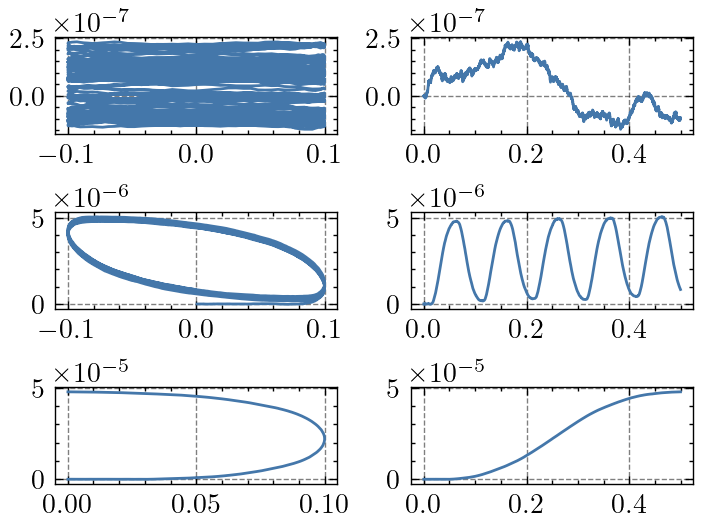

In [73]:
fig = plt.figure(dpi=200, layout='constrained')

for i, f in enumerate(f_vals):

    ax  = fig.add_subplot(3,2,2*i+1)
    ax.plot(volts[i][1:],data_string[f]['Current'])

    ax  = fig.add_subplot(3,2,2*i+2)
    ax.plot(t_vals,data_string[f]['Current'])

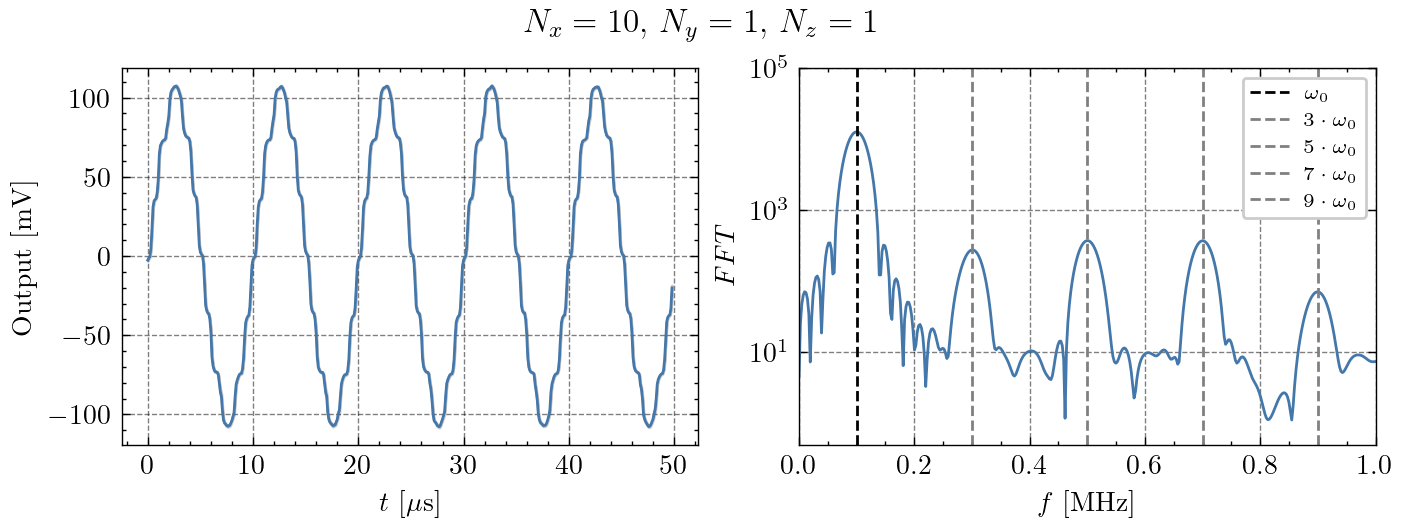

In [50]:
N_p     = 10
y_min   = 0.5
y_max   = 100000
f1      = 0.1
vals    = data_string[N_p]['Current'].values*1000
vals_e  = data_string[N_p]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, vals)
ax.fill_between(t_vals, vals-vals_e, vals+vals_e, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]')
# ax.set_xlim(0,80)

ax      = fig.add_subplot(1,2,2)
signal  = vals.copy()
signal  = signal - np.mean(signal)
xf, f   = nanonets_utils.fft(signal=signal, dt=time_step, n_padded=4096)

ax.plot(xf/1e6 ,f)
ax.vlines(f1, y_min, y_max, colors='black', ls='--', label='$\omega_0$')
ax.vlines(3*f1, y_min, y_max, colors='grey', ls='--', label='$3 \cdot \omega_0$')
ax.vlines(5*f1, y_min, y_max, colors='grey', ls='--', label='$5 \cdot \omega_0$')
ax.vlines(7*f1, y_min, y_max, colors='grey', ls='--', label='$7 \cdot \omega_0$')
ax.vlines(9*f1, y_min, y_max, colors='grey', ls='--', label='$9 \cdot \omega_0$')
ax.set_xlim(0,1)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_yscale('log')
ax.legend(ncol=1, frameon=True, fontsize='x-small', framealpha=1, loc='upper right')
fig.suptitle(f'$N_x = {N_p}$, $N_y = 1$, $N_z = 1$')
fig.savefig(f"../plots/radius_{radius}/{N_p}_string_output_fft.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/radius_{radius}/{N_p}_string_output_fft.pdf", bbox_inches='tight', transparent=False)

In [51]:
f0              = 1e5
harmonics       = []

for key, df in data_string.items():

    signal          = df['Current'].values*1000
    arr_strength    = nanonets_utils.harmonic_strength(signal=signal, f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

thd_string  = np.sqrt(np.sum(np.array(harmonics)**2, axis=1))

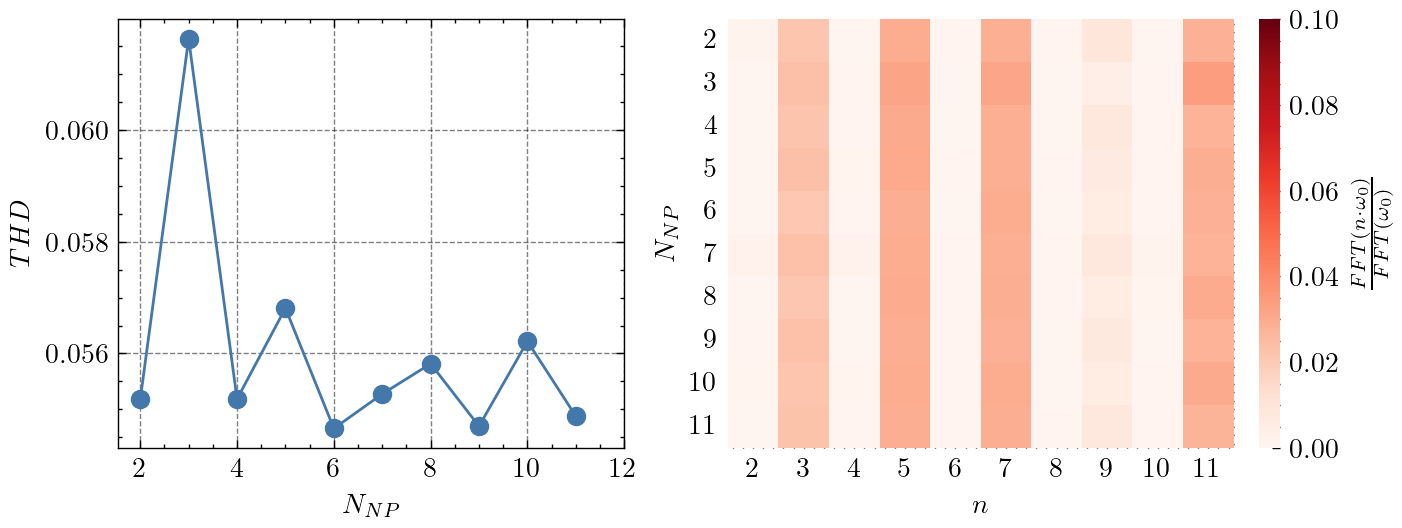

In [52]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot(1,2,1)
ax.plot(N_vals, thd_string, 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.arange(N_min,N_max+1,2))
ax.set_ylabel("$THD$")

df  = pd.DataFrame(harmonics, index=N_vals, columns=np.arange(2, len(arr_strength)+2))
ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$"},
                  vmin=0, vmax=0.1)

ax.set_ylabel("$N_{NP}$")
ax.set_xlabel("$n$")
plt.yticks(rotation=0)

fig.savefig(f"../plots/radius_{radius}/THD_string_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/radius_{radius}/THD_string_sample.pdf", bbox_inches='tight', transparent=False)

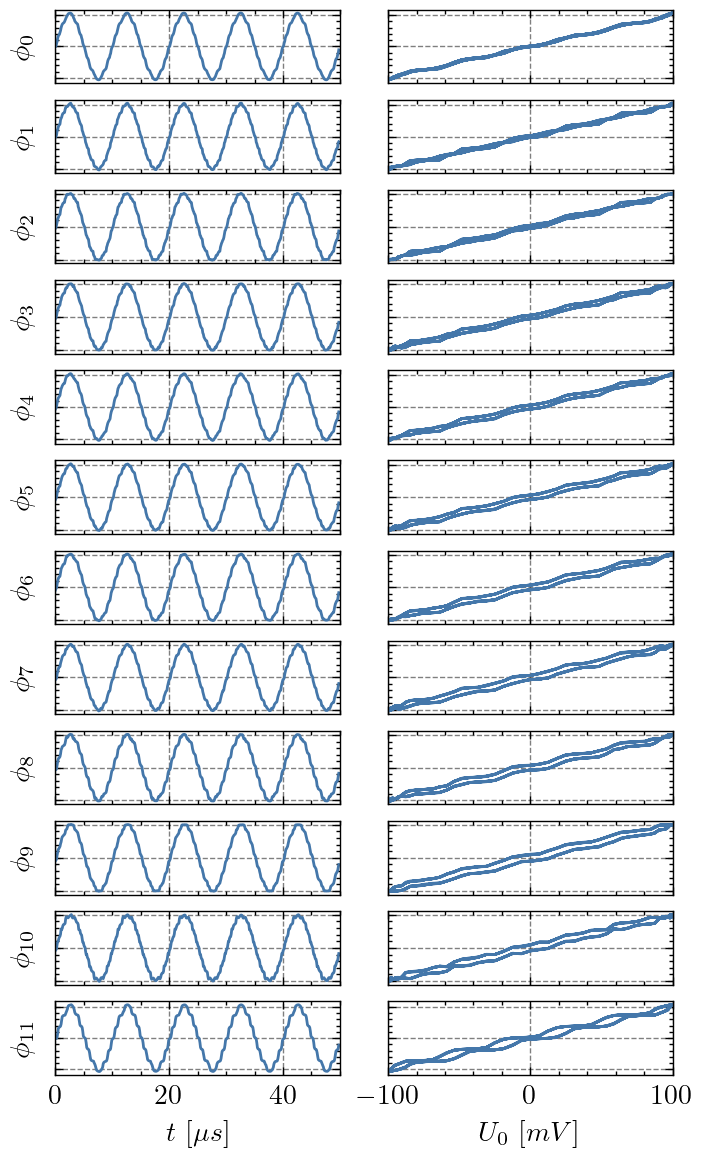

In [56]:
N_val   = 11
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*2*N_val/10)

for i in range(N_val+1):

    ax  = fig.add_subplot(N_val+1,2,2*i+1)
    arr = states_string[N_val][f"{i}"]
    ax.plot(t_vals, arr)

    ax.set_ylabel("$\phi_{"+f"{i}"+"}$")
    ax.set_xlim(0,50)
    ax.set_yticklabels("")
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [$\mu s$]")

    ax  = fig.add_subplot(N_val+1,2,2*i+2)
    ax.plot(x_vals, arr)
    ax.set_yticklabels("")
    ax.set_xlim(-100,100)
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$U_0$ [$mV$]")
    fig.savefig(f"../plots/radius_{radius}/{N_val}_string_np_responses.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"../plots/radius_{radius}/{N_val}_string_np_responses.pdf", bbox_inches='tight', transparent=False)

## Network

In [61]:
# radius          = 10.0
radius          = 1000000.0
data_network    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}
states_network  = {N : 1000*pd.read_csv(f"{path}mean_state_Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}

In [62]:
f0              = 1e5
harmonics       = []

for key, df in data_network.items():

    signal          = df['Current'].values*1000
    arr_strength    = nanonets_utils.harmonic_strength(signal=signal, f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

thd_network  = np.sqrt(np.sum(np.array(harmonics)**2, axis=1))

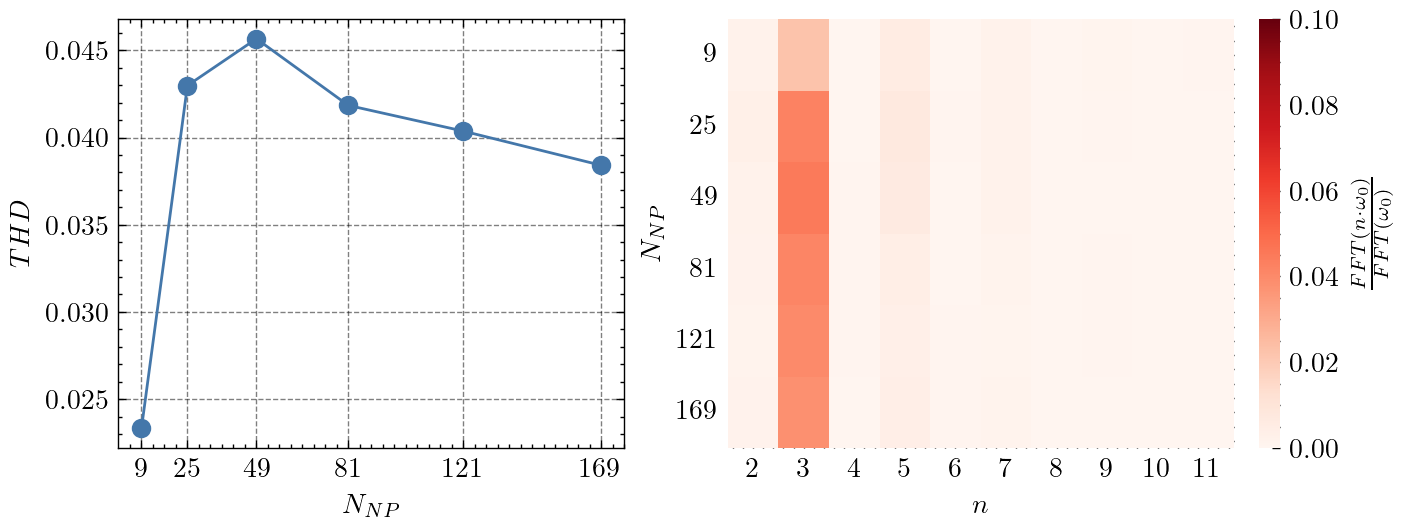

In [65]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot(1,2,1)
ax.plot(np.array([3,5,7,9,11,13])**2, thd_network, 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.array([3,5,7,9,11,13])**2)
ax.set_ylabel("$THD$")

df  = pd.DataFrame(harmonics, index=np.array([3,5,7,9,11,13])**2, columns=np.arange(2, len(arr_strength)+2))
ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$"},
                  vmin=0, vmax=0.1)

ax.set_ylabel("$N_{NP}$")
ax.set_xlabel("$n$")
plt.yticks(rotation=0)

fig.savefig(f"../plots/radius_{radius}/THD_network_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/radius_{radius}/THD_network_sample.pdf", bbox_inches='tight', transparent=False)

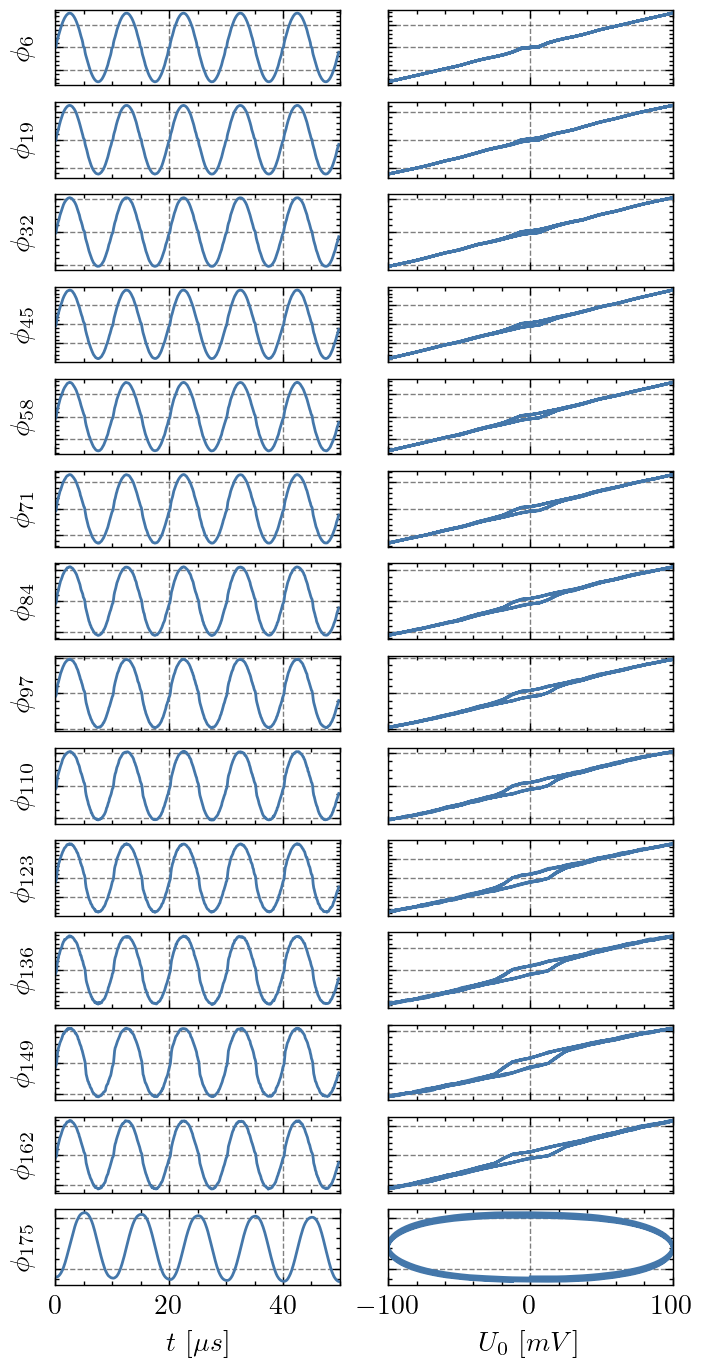

In [66]:
N_val   = 13
idx     = N_val//2
phi     = [states_network[N_val][f"{idx+i*N_val}"].values for i in range(N_val)]
phi.append(states_network[N_val][f"{N_val**2}"].values)

fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*2*N_val/10)

for i, arr in enumerate(phi):

    ax  = fig.add_subplot(N_val+1,2,2*i+1)
    ax.plot(t_vals, arr)

    ax.set_ylabel("$\phi_{"+f"{idx+i*N_val}"+"}$")
    ax.set_xlim(0,50)
    ax.set_yticklabels("")
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [$\mu s$]")

    ax  = fig.add_subplot(N_val+1,2,2*i+2)
    ax.plot(x_vals, arr)
    ax.set_yticklabels("")
    ax.set_xlim(-100,100)
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$U_0$ [$mV$]")
        
    fig.savefig(f"../plots/radius_{radius}/{N_val}_network_np_responses.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"../plots/radius_{radius}/{N_val}_network_np_responses.pdf", bbox_inches='tight', transparent=False)

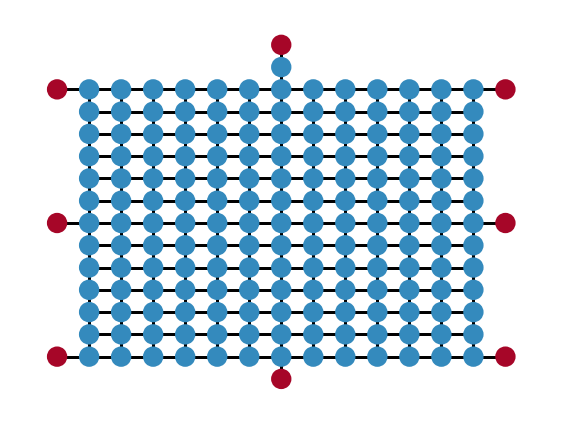

In [346]:
from system_size import return_network_topology

t_arr       = return_network_topology(N_val)
sim_class   = nanonets.simulation(t_arr)
fig, ax     = plt.subplots(dpi=200)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=40)
fig.savefig(f"../plots/{N_val}_{N_val}_network.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/{N_val}_{N_val}_network.pdf", bbox_inches='tight', transparent=False)

---